In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from tab2img.converter import Tab2Img
from PIL import Image
import os
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import cv2
import numpy as np
import pathlib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score,recall_score

2022-10-07 12:16:24.016741: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
def data_create():
    data = load_breast_cancer()
    X = data.data
    y = data.target
    return X,y

def image_conversion(X,y):
    model = Tab2Img()
    images = model.fit_transform(X, y)
    return images, model

In [3]:
IMAGE_SHAPE =(224,224)
classifier = tf.keras.Sequential([
    hub.KerasLayer("http://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4",input_shape = IMAGE_SHAPE+(3,))
])

2022-10-07 12:16:24.940156: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-10-07 12:16:26.604640: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-10-07 12:16:26.605179: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 1 with properties: 
pciBusID: 0000:65:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-10-07 12:16:26.605660: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 2 with properties: 
pciBusID: 0000:0a:00.0 name: TITAN Xp COLLECTORS EDITION computeCapability: 6.1
coreClock: 1.582GHz coreCount: 30 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 510.0

In [4]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [5]:
def baseline_method(X_train, X_test, y_train, y_test):
    logisticRegr = LogisticRegression()
    logisticRegr.fit(X_train,y_train)
    prediction = logisticRegr.predict(X_test)
    accuracy = accuracy_score(y_test, prediction)
    precision = precision_score(y_test, prediction, average='macro')
    recall = recall_score(y_test, prediction, average='macro')
    f_score = 2*precision*recall/(precision+recall)
    
    return accuracy, precision, recall, f_score,prediction
    
    

In [6]:
X,y = data_create()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [7]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)

(569, 30)
(426, 30)
(143, 30)


In [8]:
train_images,model = image_conversion(X_train, y_train)
test_images = model.transform(X_test)

In [9]:
print(train_images.shape)
print(test_images.shape)

(426, 6, 6)
(143, 6, 6)


In [10]:
# make all the image from the features

# classes = [i for i in np.unique(y)]

directory_train = "train_tabular"
directory_test = "test_tabular"
parent_dir = "./"
slash = "/"

cnt = 0
for i in range(train_images.shape[0]):
    nparray = train_images[i].reshape(train_images.shape[1],train_images.shape[1])
    image = Image.fromarray(nparray * 255)
    image = image.convert('RGB')
    path_train = os.path.join(parent_dir, directory_train,str(y_train[cnt]))
    os.makedirs(path_train,exist_ok=True)
    image.save(f'{path_train}{slash}{i}.jpg')
    cnt+=1
print("Number of train data is:",cnt)
    
cnt = 0
for i in range(test_images.shape[0]):
    nparray = test_images[i].reshape(train_images.shape[1],train_images.shape[1])
    image = Image.fromarray(nparray * 255)
    image = image.convert('RGB')
    path_test = os.path.join(parent_dir, directory_test,str(y_test[cnt]))
    os.makedirs(path_test,exist_ok=True)
    image.save(f'{path_test}{slash}{i}.jpg')
    cnt+=1
print("Number of test data is:",cnt)

Number of train data is: 426
Number of test data is: 143


In [11]:
train_data_dir = pathlib.Path("train_tabular/")
test_data_dir = pathlib.Path("test_tabular/")

In [12]:
train_data_dir

PosixPath('train_tabular')

In [13]:
print(train_data_dir)
print(test_data_dir)


train_tabular
test_tabular


In [14]:
image_count_train = len(list(train_data_dir.glob("*/*.jpg")))
image_count_test = len(list(test_data_dir.glob("*/*.jpg")))

In [15]:
print("Total train images:",image_count_train)
print("Total test images:",image_count_test)

Total train images: 426
Total test images: 143


In [16]:
imgs = list(train_data_dir.glob("0/*.*"))
imgs[:5]

[PosixPath('train_tabular/0/341.jpg'),
 PosixPath('train_tabular/0/31.jpg'),
 PosixPath('train_tabular/0/351.jpg'),
 PosixPath('train_tabular/0/109.jpg'),
 PosixPath('train_tabular/0/40.jpg')]

In [17]:
train_images_dict = {
    'malignant':list(train_data_dir.glob("1/*.*")),
    'benign': list(train_data_dir.glob("0/*.*"))
}

test_images_dict = {
    'malignant':list(test_data_dir.glob("1/*.*")),
    'benign': list(test_data_dir.glob("0/*.*"))
}

In [18]:
labels_dict = {
    'malignant': 1,
    'benign': 0
}

In [19]:
X_train, y_train=[],[]
for cancer_status, images in train_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,IMAGE_SHAPE)
        X_train.append(resized_img)
        y_train.append(labels_dict[cancer_status])


In [20]:
X_test, y_test=[],[]
for cancer_status, images in test_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,IMAGE_SHAPE)
        X_test.append(resized_img)
        y_test.append(labels_dict[cancer_status])


In [21]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [22]:
X_train_scaled = X_train/255.0
X_test_scaled = X_test/255.0

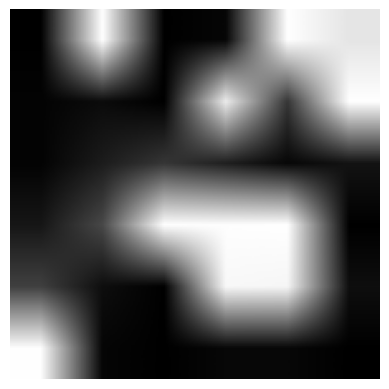

In [23]:
plt.axis("off")
plt.imshow(X_train[0])

In [24]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
pretrained_model_without_top_layer = hub.KerasLayer(
feature_extractor_model, input_shape=(224,224,3),trainable = False)

In [25]:
num_of_labels = 2
model = tf.keras.Sequential([
    pretrained_model_without_top_layer,
    tf.keras.layers.Dense(num_of_labels,activation=tf.nn.softmax)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [26]:
model.compile(
    optimizer="adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ["acc"]
)
model.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100


2022-10-07 12:16:33.293920: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-10-07 12:16:33.535670: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7


14/14 [==============================] - 0s 23ms/step - loss: 0.6142 - acc: 0.6995
Epoch 2/100
14/14 [==============================] - 0s 18ms/step - loss: 0.5691 - acc: 0.7488
Epoch 3/100
14/14 [==============================] - 0s 19ms/step - loss: 0.5338 - acc: 0.7653
Epoch 4/100
14/14 [==============================] - 0s 19ms/step - loss: 0.5075 - acc: 0.8333
Epoch 5/100
14/14 [==============================] - 0s 19ms/step - loss: 0.4907 - acc: 0.8521
Epoch 6/100
14/14 [==============================] - 0s 19ms/step - loss: 0.4830 - acc: 0.8521
Epoch 7/100
14/14 [==============================] - 0s 19ms/step - loss: 0.4756 - acc: 0.8568
Epoch 8/100
14/14 [==============================] - 0s 19ms/step - loss: 0.4724 - acc: 0.8521
Epoch 9/100
14/14 [==============================] - 0s 19ms/step - loss: 0.4685 - acc: 0.8592
Epoch 10/100
14/14 [==============================] - 0s 19ms/step - loss: 0.4642 - acc: 0.8662
Epoch 11/100
14/14 [==============================] - 0s 19ms

In [27]:
# model.evaluate(X_test_scaled, y_test)

In [28]:
predicted_class = model.predict_classes(X_test_scaled)
pred_prob = model.predict(X_test_scaled)
pred_prob = np.around(pred_prob, decimals=3)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


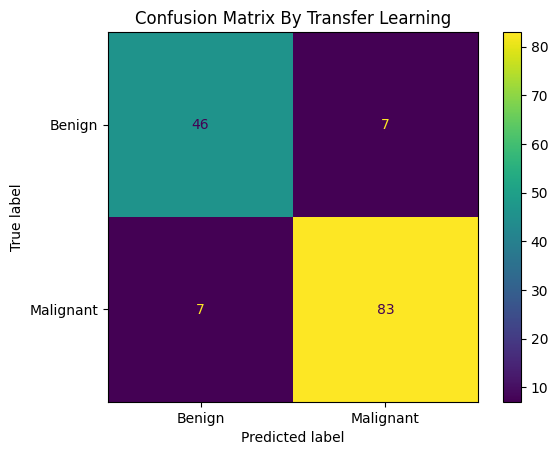

In [29]:
cm = confusion_matrix(y_test, predicted_class, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Benign","Malignant"])
disp.plot()
plt.title("Confusion Matrix By Transfer Learning")
plt.show()

In [30]:
predicted_class = model.predict_classes(X_test_scaled)
precision = precision_score(y_test, predicted_class, average='macro')
recall = recall_score(y_test, predicted_class, average='macro')
f_score = 2*precision*recall/(precision+recall)
accuracy = accuracy_score(y_test,predicted_class)
print("Transfer Learning with Image Classification")
print(f"Accuracy:{round(accuracy,3)},Precision:{round(precision,3)},Recall:{round(recall,3)},F1-score:{round(f_score,3)}")

Transfer Learning with Image Classification
Accuracy:0.902,Precision:0.895,Recall:0.895,F1-score:0.895


In [31]:
# Result from the baseline logistic regression method
X,y = data_create()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)
accuracy,precision, recall, f_score,predicted_class = baseline_method(X_train, X_test, y_train, y_test)


/home/mohan/anaconda3/envs/keras/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


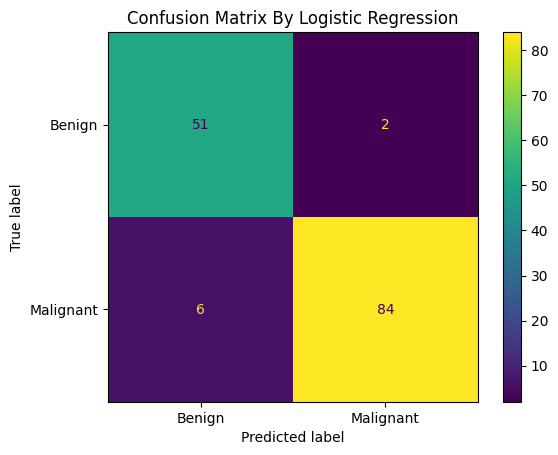

In [32]:
cm = confusion_matrix(y_test, predicted_class, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Benign","Malignant"])
disp.plot()
plt.title("Confusion Matrix By Logistic Regression")
plt.show()

In [33]:
print("Baseline Logistic Regression Classifier")
print(f"Accuracy:{round(accuracy,3)},Precision:{round(precision,3)},Recall:{round(recall,3)},F1-score:{round(f_score,3)}")

Baseline Logistic Regression Classifier
Accuracy:0.944,Precision:0.936,Recall:0.948,F1-score:0.942
